In [9]:
DATA_XLSX = '/content/drive/MyDrive/<your_path>/air_quality_index_dataset.xlsx'


In [10]:
# === Setup / Config ===
# If running on Colab, uncomment the next 3 lines and set your Drive path:
from google.colab import drive
drive.mount('/content/drive')
DATA_XLSX = '/content/drive/MyDrive/air_quality_index_dataset.xlsx'

SAVE_DIR = 'outputs'
os.makedirs(SAVE_DIR, exist_ok=True)

POLLUTANT_ALIASES = {
  "pm2.5": [
    "pm2.5",
    "pm2_5",
    "pm25",
    "pm 2.5",
    "pm-2.5",
    "pm2-5"
  ],
  "co": [
    "co",
    "carbon_monoxide",
    "carbon monoxide"
  ],
  "o3": [
    "o3",
    "ozone"
  ],
  "so2": [
    "so2",
    "sulfur_dioxide",
    "sulphur_dioxide",
    "sulfur dioxide",
    "sulphur dioxide"
  ],
  "no": [
    "no",
    "nitric_oxide",
    "nitric oxide"
  ],
  "no2": [
    "no2",
    "nitrogen_dioxide",
    "nitrogen dioxide"
  ],
  "nox": [
    "nox",
    "nitrogen_oxides",
    "nitrogen oxides"
  ]
}

# Choose how many PCA components to use for the pollutant gases (for visualization we'll use 2)
N_PCA = 2

# Range of k to explore for KMeans
K_MIN, K_MAX = 2, 10


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# === Imports ===
import os, re, math
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)


In [12]:
# === Load & Merge All Sheets ===
def standardize_columns(cols):
    # lower-case and replace spaces/specials with underscore
    def fix(c):
        return re.sub(r'[^a-z0-9]+', '_', str(c).strip().lower()).strip('_')
    return [fix(c) for c in cols]

def find_best_match(col_map, target, aliases_dict):
    # Return the standardized column in col_map that matches any alias for 'target'
    aliases = aliases_dict.get(target, [])
    for a in aliases:
        a_std = re.sub(r'[^a-z0-9]+', '_', a.lower()).strip('_')
        for c in col_map:
            if c == a_std:
                return c
    return None

xls = pd.ExcelFile(DATA_XLSX)
frames = []
for sn in xls.sheet_names:
    df = pd.read_excel(xls, sn)
    df.columns = standardize_columns(df.columns)
    df['source_sheet'] = sn
    frames.append(df)

data = pd.concat(frames, ignore_index=True)
print(f"Merged shape: {data.shape}")
print("Columns:", list(data.columns)[:30])
data.head()


Merged shape: (944182, 23)
Columns: ['date', 'time', 'so2', 'no', 'no2', 'nox', 'co', 'co_8hr', 'o3', 'o3_8hr', 'pm2_5', 'pm10', 'wind_speed', 'wind_dir', 'temperature', 'rh', 'solar_rad', 'bp', 'rain', 'v_wind_speed', 'unnamed_20', 'source_sheet', 'unnamed_21']


,date,time,so2,no,no2,nox,co,co_8hr,o3,o3_8hr,...,wind_dir,temperature,rh,solar_rad,bp,rain,v_wind_speed,unnamed_20,source_sheet,unnamed_21
0,2012-11-01 00:00:00,01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sangsad,NaN
1,2012-11-01 00:00:00,02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sangsad,NaN
2,2012-11-01 00:00:00,03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sangsad,NaN
3,2012-11-01 00:00:00,04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sangsad,NaN
4,2012-11-01 00:00:00,05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sangsad,NaN


In [13]:
# === Preprocessing: select key features, impute, scale, PCA ===
# Identify columns
colnames = list(data.columns)

def match_or_warn(target):
    c = find_best_match(colnames, target, POLLUTANT_ALIASES)
    if c is None:
        print(f"[WARN] Could not find column for '{target}'. Check your column names.")
    return c

pm_col = match_or_warn('pm2.5')
co_col = match_or_warn('co')
o3_col = match_or_warn('o3')
so2_col = match_or_warn('so2')
no_col = match_or_warn('no')
no2_col = match_or_warn('no2')
nox_col = match_or_warn('nox')

required = [pm_col, co_col, o3_col, so2_col, no_col, no2_col, nox_col]
required = [c for c in required if c is not None]

df = data[required + ['source_sheet']].copy()
# Ensure numeric
for c in required:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Impute missing with median
imp = SimpleImputer(strategy='median')
df_imputed = df.copy()
df_imputed[required] = imp.fit_transform(df_imputed[required])

# Scale pollutants for PCA (excluding PM2.5)
pollutants = [co_col, o3_col, so2_col, no_col, no2_col, nox_col]
pollutants = [c for c in pollutants if c in df_imputed.columns]
scaler = StandardScaler()
pollutant_scaled = scaler.fit_transform(df_imputed[pollutants])

# PCA to 2 components for visualization
pca = PCA(n_components=min(2, len(pollutants)))
pca_features = pca.fit_transform(pollutant_scaled)
df_imputed['pca1'] = pca_features[:,0]
if pca.n_components_ > 1:
    df_imputed['pca2'] = pca_features[:,1]
else:
    df_imputed['pca2'] = 0.0

# Compose features for KMeans: PM2.5 + PCA1 + PCA2
X = np.column_stack([df_imputed[pm_col].values, df_imputed['pca1'].values, df_imputed['pca2'].values])

# Scale X for KMeans
scaler_k = StandardScaler()
X_scaled = scaler_k.fit_transform(X)

print("Prepared feature matrix shape:", X_scaled.shape)


Prepared feature matrix shape: (944182, 3)


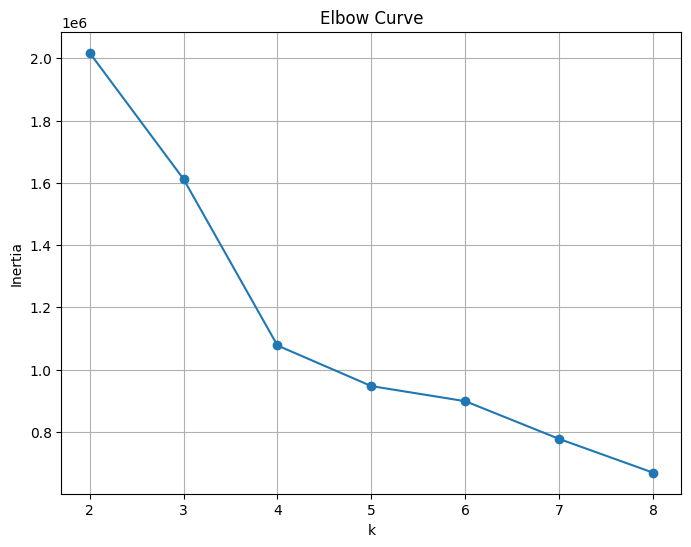

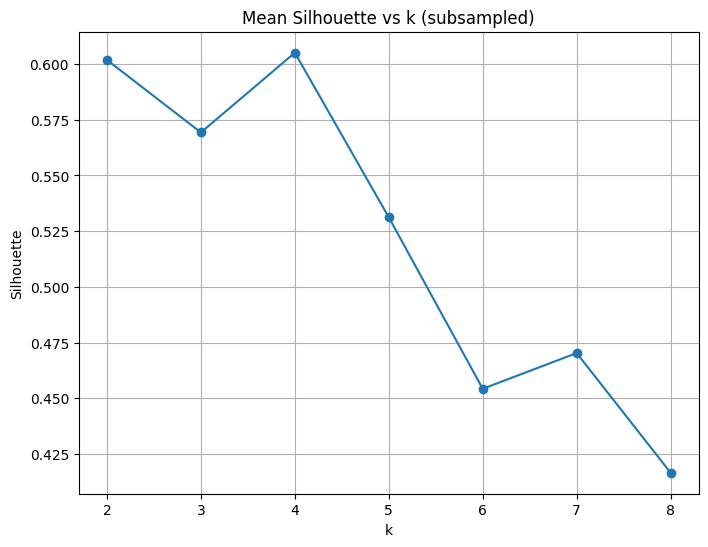

Selected k (by subsampled silhouette): 4


In [14]:
# === Elbow (Inertia) & Silhouette Analysis [FAST] ===
from sklearn.cluster import MiniBatchKMeans

USE_MINIBATCH = True          # faster KMeans
SIL_SAMPLE_SIZE = 5000        # try 2000–10000 depending on RAM
K_MIN, K_MAX = 2, 8           # shrink the k range to speed up

ks = list(range(K_MIN, K_MAX + 1))
inertias, silhouettes = [], []

def fit_kmeans(k):
    if USE_MINIBATCH:
        # MiniBatchKMeans is much faster on large n
        km = MiniBatchKMeans(n_clusters=k, random_state=42, n_init="auto", batch_size=2048)
    else:
        km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X_scaled)
    return km, labels

for k in ks:
    km, labels = fit_kmeans(k)
    inertias.append(km.inertia_)
    if k > 1:
        sil = silhouette_score(X_scaled, labels, sample_size=min(SIL_SAMPLE_SIZE, X_scaled.shape[0]),
                               random_state=42)
    else:
        sil = float("nan")
    silhouettes.append(sil)

# plots (unchanged)
plt.figure(); plt.plot(ks, inertias, marker='o'); plt.title("Elbow Curve"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.grid(True); plt.show()
plt.figure(); plt.plot(ks, silhouettes, marker='o'); plt.title("Mean Silhouette vs k (subsampled)"); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True); plt.show()

valid_sils = [(k, s) for k, s in zip(ks, silhouettes) if not np.isnan(s)]
best_k = max(valid_sils, key=lambda t: t[1])[0] if valid_sils else 3
print(f"Selected k (by subsampled silhouette): {best_k}")


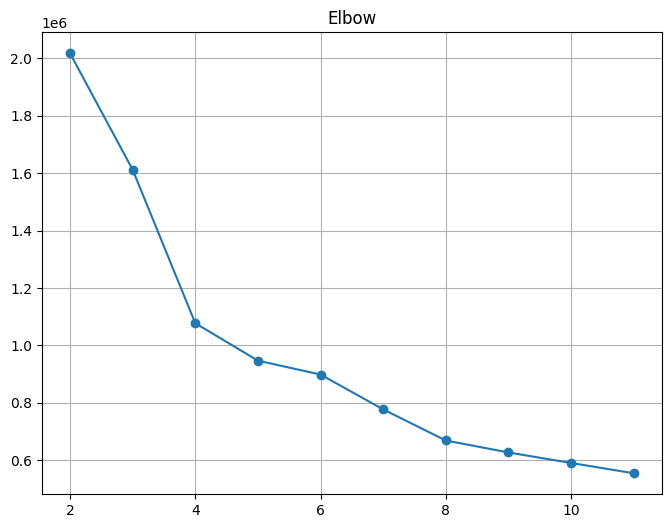

/tmp/ipython-input-2450220704.py:16: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(p2-p1, np.column_stack([x, y]) - p1)) / np.linalg.norm(p2-p1)


k candidates: [3, 4, 5]
k=3 silhouette=0.5693
k=4 silhouette=0.6050
k=5 silhouette=0.5312
Selected k: 4


In [15]:
# 1) elbow over more k, no silhouette in the loop
Ks = range(2, 12)
inertias = []
for k in Ks:
    km = MiniBatchKMeans(n_clusters=k, random_state=42, n_init="auto", batch_size=2048)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(); plt.plot(list(Ks), inertias, marker='o'); plt.title("Elbow"); plt.grid(True); plt.show()

# 2) pick candidates near the elbow (simple knee heuristic)
import numpy as np
x = np.array(list(Ks)); y = np.array(inertias, dtype=float)
# distance from line between first & last points
p1, p2 = np.array([x[0], y[0]]), np.array([x[-1], y[-1]])
dist = np.abs(np.cross(p2-p1, np.column_stack([x, y]) - p1)) / np.linalg.norm(p2-p1)
knee = int(x[np.argmax(dist)])

candidates = sorted(set([max(2, knee-1), knee, min(knee+1, x[-1])]))
print("k candidates:", candidates)

# 3) now compute silhouette only for candidates (with subsampling)
best_k, best_s = None, -1
for k in candidates:
    km = MiniBatchKMeans(n_clusters=k, random_state=42, n_init="auto", batch_size=2048)
    labels = km.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, labels, sample_size=min(5000, X_scaled.shape[0]), random_state=42)
    print(f"k={k} silhouette={s:.4f}")
    if s > best_s: best_s, best_k = s, k

print("Selected k:", best_k)


In [16]:
# === Fit Final K-Means [FAST: MiniBatch] ===
from sklearn.cluster import MiniBatchKMeans

# downcast to float32 to speed math & cut RAM
X_mb = X_scaled.astype(np.float32, copy=False)

mbk = MiniBatchKMeans(
    n_clusters=best_k,
    random_state=42,
    n_init="auto",
    batch_size=4096,          # try 2048–8192 in Colab
    max_no_improvement=20,    # early stop if inertia plateaus
    reassignment_ratio=0.001  # stabilizes tiny clusters
)
labels = mbk.fit_predict(X_mb)

df_imputed['kmeans_label'] = labels
sizes = pd.Series(labels).value_counts().sort_index()
print("Cluster sizes:\n", sizes)

# quick quality read
from sklearn.metrics import silhouette_score
mean_sil = silhouette_score(X_mb, labels, sample_size=min(5000, X_mb.shape[0]), random_state=42)
print(f"Mean silhouette (subsampled, k={best_k}): {mean_sil:.4f}")


Cluster sizes:
 0     69027
1    100102
2    737828
3     37225
Name: count, dtype: int64
Mean silhouette (subsampled, k=4): 0.6032


In [17]:
from sklearn.cluster import MiniBatchKMeans, KMeans
import numpy as np

X32 = X_scaled.astype(np.float32, copy=False)

# 1) Fast pass
seed = MiniBatchKMeans(n_clusters=best_k, random_state=42, n_init="auto",
                       batch_size=4096, max_no_improvement=15)
seed.fit(X32)
centers = seed.cluster_centers_.astype(np.float64, copy=False)  # KMeans expects float64

# 2) Quick refine with few iterations (Elkan is faster for Euclidean)
kmeans = KMeans(
    n_clusters=best_k,
    init=centers,
    n_init=1,                 # we already have good centers
    max_iter=100,             # keep small to be quick
    tol=1e-3,
    algorithm="elkan",
    random_state=42
)
labels = kmeans.fit_predict(X32)

df_imputed['kmeans_label'] = labels
print("Cluster sizes:\n", pd.Series(labels).value_counts().sort_index())


Cluster sizes:
 0     64227
1    101945
2    740986
3     37024
Name: count, dtype: int64


In [18]:
from sklearn.cluster import KMeans

X32 = X_scaled.astype(np.float32, copy=False)

kmeans = KMeans(
    n_clusters=best_k,
    init="k-means++",
    n_init=10,        # keep moderate
    max_iter=150,     # lower than default 300
    tol=1e-3,         # slightly looser tolerance
    algorithm="elkan",
    random_state=42
)
labels = kmeans.fit_predict(X32)
df_imputed['kmeans_label'] = labels


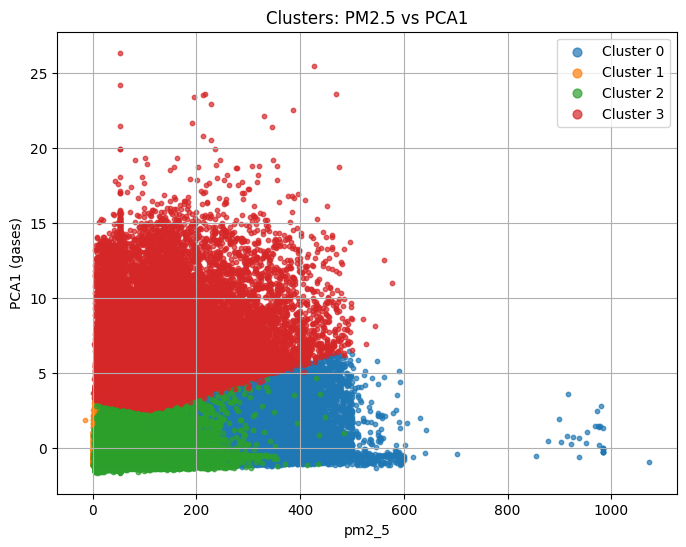

In [19]:
# === Visualization: PM2.5 vs PCA1 (colored by cluster) ===
plt.figure()
for c in sorted(df_imputed['kmeans_label'].unique()):
    mask = df_imputed['kmeans_label'] == c
    plt.scatter(df_imputed.loc[mask, pm_col],
                df_imputed.loc[mask, 'pca1'],
                s=10, alpha=0.7, label=f'Cluster {c}')
plt.title("Clusters: PM2.5 vs PCA1")
plt.xlabel(pm_col)
plt.ylabel("PCA1 (gases)")
plt.legend(markerscale=2)
plt.grid(True)
plt.show()


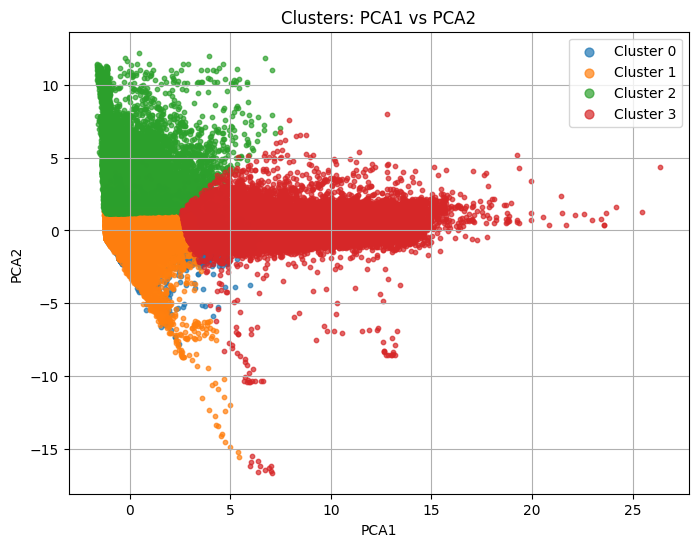

In [20]:
# === Visualization: PCA1 vs PCA2 (colored by cluster) ===
plt.figure()
for c in sorted(df_imputed['kmeans_label'].unique()):
    mask = df_imputed['kmeans_label'] == c
    plt.scatter(df_imputed.loc[mask, 'pca1'],
                df_imputed.loc[mask, 'pca2'],
                s=10, alpha=0.7, label=f'Cluster {c}')
plt.title("Clusters: PCA1 vs PCA2")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(markerscale=2)
plt.grid(True)
plt.show()


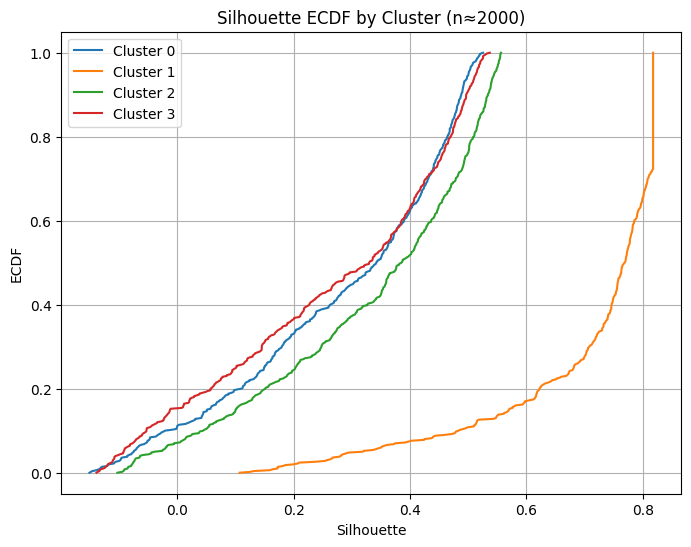

In [21]:
from sklearn.metrics import silhouette_samples
import numpy as np
import matplotlib.pyplot as plt

MAX_POINTS = 2000         # lower = faster (try 500–2000)
X_for_sil = X_scaled.astype(np.float32, copy=False)
labels_all = df_imputed['kmeans_label'].values
clusters = np.unique(labels_all)

# stratified sampling: same-ish count per cluster
n_per = max(1, MAX_POINTS // len(clusters))
idx_keep = []

rng = np.random.default_rng(42)
for c in clusters:
    idx_c = np.flatnonzero(labels_all == c)
    take = min(n_per, len(idx_c))
    if take > 0:
        idx_keep.append(rng.choice(idx_c, size=take, replace=False))
idx_keep = np.concatenate(idx_keep) if len(idx_keep) else np.arange(min(MAX_POINTS, X_for_sil.shape[0]))

X_sub = X_for_sil[idx_keep]
y_sub = labels_all[idx_keep]

# per-sample silhouettes only on the subset (MUCH faster)
sil_vals = silhouette_samples(X_sub, y_sub)

# quick ECDF-style silhouette view per cluster
plt.figure()
for c in clusters:
    vals = sil_vals[y_sub == c]
    if vals.size == 0:
        continue
    vals_sorted = np.sort(vals)
    ecdf = np.linspace(0, 1, vals_sorted.size)
    plt.plot(vals_sorted, ecdf, label=f"Cluster {c}")
plt.title(f"Silhouette ECDF by Cluster (n≈{len(idx_keep)})")
plt.xlabel("Silhouette")
plt.ylabel("ECDF")
plt.grid(True)
plt.legend()
plt.show()


In [22]:
# === Cluster Profiling (means per cluster in original scale) ===
profile_cols = [pm_col] + [c for c in [co_col, o3_col, so2_col, no_col, no2_col, nox_col] if c is not None]
cluster_profile = df_imputed.groupby('kmeans_label')[profile_cols].mean().round(3)
display(cluster_profile)

# Save outputs
out_csv = os.path.join(SAVE_DIR, 'aqi_with_kmeans_labels.csv')
df_imputed.to_csv(out_csv, index=False)
print("Saved:", out_csv)


,pm2_5,co,o3,so2,no,no2,nox
kmeans_label,,,,,,,
0,200.927,2.072,5.007,7.995,18.803,14.397,32.170
1,49.430,1.285,5.585,4.829,7.768,9.250,15.745
2,69.519,1.103,40.573,5.031,6.985,11.722,17.021
3,114.876,2.265,5.676,9.846,127.921,49.465,163.268


Saved: outputs/aqi_with_kmeans_labels.csv


In [23]:
# === Appendix: Utility display ===
print("PCA explained variance ratio:", pca.explained_variance_ratio_)


PCA explained variance ratio: [0.39104467 0.16797718]


In [24]:
# === METRICS: K-Means (self-healing) ===
import re, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def _std(s): return re.sub(r'[^a-z0-9]+','_', str(s).lower()).strip('_')

# 1) Find or rebuild X_scaled
X_eval = None
for name in ['X_scaled','X32','X_mb','X']:
    if name in globals():
        X_eval = globals()[name]
        break

if X_eval is None:
    assert 'df_imputed' in globals(), "df_imputed not found — run preprocessing first."
    cols = list(df_imputed.columns)
    cmap = {_std(c): c for c in cols}
    # try to infer PM2.5 column
    pm_candidates = ['pm2_5','pm25','pm_2_5','pm2_5_value']
    pm_col = next((cmap[k] for k in pm_candidates if k in cmap), None)
    if pm_col is None:
        pm_col = next((orig for std, orig in cmap.items() if std.startswith('pm2')), None)
    if pm_col is None:
        raise ValueError("Couldn’t infer PM2.5 column. Set pm_col='YOUR_PM_COL' and rerun.")

    if 'pca1' not in df_imputed.columns:
        raise ValueError("pca1 missing — run the PCA cell first.")
    if 'pca2' not in df_imputed.columns:
        df_imputed['pca2'] = 0.0

    X = np.column_stack([df_imputed[pm_col].values,
                         df_imputed['pca1'].values,
                         df_imputed['pca2'].values])
    X_eval = StandardScaler().fit_transform(X)
    print("Rebuilt X_scaled from:", [pm_col, 'pca1', 'pca2'])

# 2) Get labels
labels_km = None
if 'kmeans_label' in df_imputed.columns:
    labels_km = df_imputed['kmeans_label'].values
elif 'kmeans' in globals() and hasattr(kmeans, 'labels_'):
    labels_km = kmeans.labels_
elif 'mbk' in globals() and hasattr(mbk, 'labels_'):
    labels_km = mbk.labels_
else:
    raise ValueError("No K-Means labels found. Fit the model or ensure df_imputed['kmeans_label'] exists.")

# 3) Compute metrics (safe)
uniq = np.unique(labels_km)
if uniq.size <= 1:
    km_scores = {'silhouette': np.nan, 'calinski_harabasz': np.nan, 'davies_bouldin': np.nan}
else:
    n = X_eval.shape[0]
    km_scores = {
        'silhouette': silhouette_score(X_eval, labels_km, sample_size=min(5000, n), random_state=42),
        'calinski_harabasz': calinski_harabasz_score(X_eval, labels_km),
        'davies_bouldin': davies_bouldin_score(X_eval, labels_km)
    }

# 4) Inertia (if available)
inertia = None
for m in ['kmeans','mbk']:
    if m in globals() and hasattr(globals()[m], 'inertia_'):
        inertia = getattr(globals()[m], 'inertia_')
        break

row = {
    'k': int(globals().get('best_k', np.nan)),
    'Inertia(SSE)': inertia,
    'Silhouette(↑)': km_scores['silhouette'],
    'Calinski–Harabasz(↑)': km_scores['calinski_harabasz'],
    'Davies–Bouldin(↓)': km_scores['davies_bouldin'],
}
print(row)

# optional: nice table + save
summary = pd.DataFrame([row])
display(summary)
import os; os.makedirs('outputs', exist_ok=True)
summary.to_csv('outputs/kmeans_metric_summary.csv', index=False)
print("Saved -> outputs/kmeans_metric_summary.csv")


{'k': 4, 'Inertia(SSE)': 1072951.25, 'Silhouette(↑)': np.float64(0.6030700723958189), 'Calinski–Harabasz(↑)': np.float64(514512.64376219123), 'Davies–Bouldin(↓)': np.float64(0.8119847546383401)}


,k,Inertia(SSE),Silhouette(↑),Calinski–Harabasz(↑),Davies–Bouldin(↓)
0,4,1072951.25,0.60307,514512.643762,0.811985


Saved -> outputs/kmeans_metric_summary.csv


,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,2,2.011874e+06,0.596227,381216.28125,1.125541
1,3,1.472708e+06,0.601448,435428.87500,0.982535
2,4,1.074868e+06,0.603246,513672.68750,0.811943
3,5,9.687758e+05,0.447745,455079.25000,0.984031
4,6,8.428206e+05,0.465918,446015.12500,0.957713
5,7,7.246388e+05,0.475391,459498.00000,0.891519
6,8,6.715282e+05,0.513891,434973.75000,0.927707
7,9,6.245336e+05,0.447906,417672.09375,0.950094
8,10,5.731700e+05,0.464492,415374.50000,0.913488


Saved -> outputs/kmeans_metrics_by_k.csv
best_k (by silhouette): 4


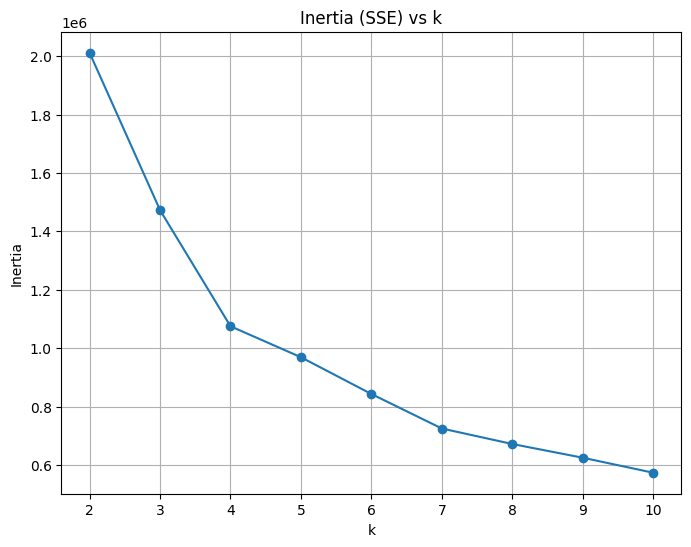

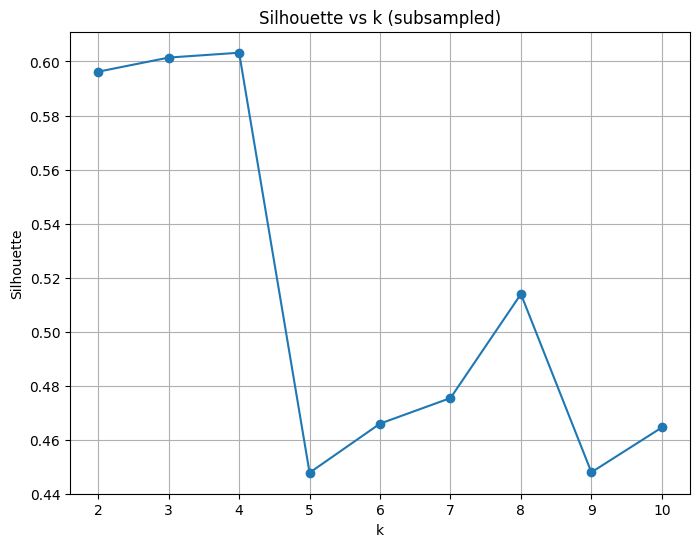

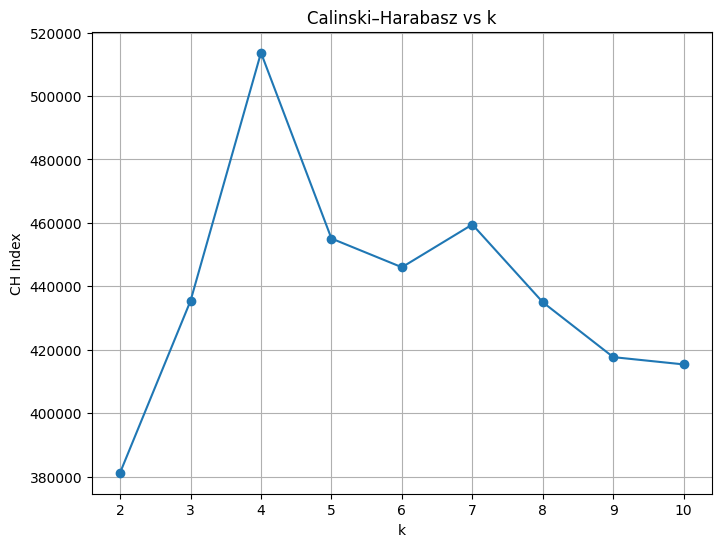

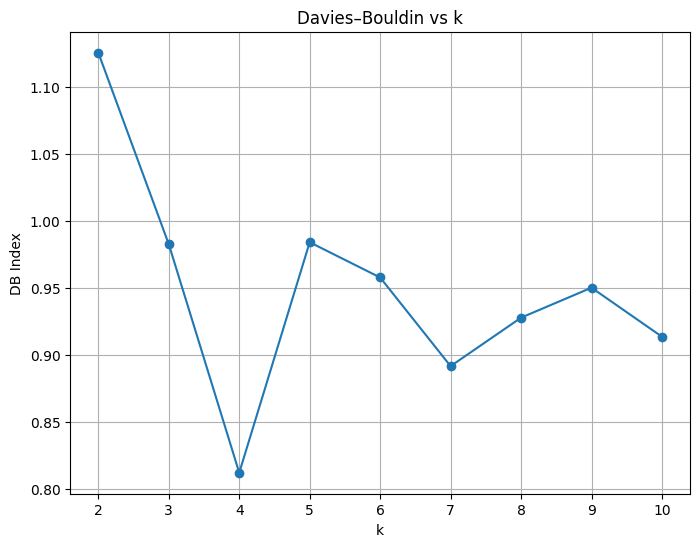

In [25]:
# === K-MEANS METRICS ACROSS k (FAST) ===
import re, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# ---- knobs you can change ----
K_MIN, K_MAX = 2, 10          # range of k to evaluate
USE_MINIBATCH = True          # speed: True = MiniBatchKMeans, False = regular KMeans
BATCH_SIZE = 4096             # MiniBatch size (try 2048–8192)
SIL_SAMPLE_SIZE = 5000        # subsample size for silhouette (speed + stability)
RANDOM_STATE = 42
# ------------------------------

def _std(s): return re.sub(r'[^a-z0-9]+', '_', str(s).lower()).strip('_')

# 0) Find or rebuild X_scaled (PM2.5 + PCA1 + PCA2) if needed
if 'X_scaled' not in globals():
    assert 'df_imputed' in globals(), "df_imputed missing — run preprocessing first."
    cols = list(df_imputed.columns)
    cmap = {_std(c): c for c in cols}
    pm_col = None
    for key in ['pm2_5','pm25','pm_2_5','pm2','pm2_5_value']:
        if key in cmap:
            pm_col = cmap[key]; break
    if pm_col is None:
        # fallback: first column starting with 'pm2'
        pm_col = next((orig for std, orig in cmap.items() if std.startswith('pm2')), None)
    assert pm_col is not None, "Couldn’t infer PM2.5 column; set pm_col manually."

    assert 'pca1' in df_imputed.columns, "pca1 missing — run the PCA cell first."
    if 'pca2' not in df_imputed.columns:
        df_imputed['pca2'] = 0.0

    X_raw = np.column_stack([df_imputed[pm_col].values,
                             df_imputed['pca1'].values,
                             df_imputed['pca2'].values])
    X_scaled = StandardScaler().fit_transform(X_raw)
    print("Rebuilt X_scaled from:", [pm_col, 'pca1', 'pca2'])

X_eval = X_scaled.astype(np.float32, copy=False)

def fit_and_score(k, X, use_minibatch=True):
    if use_minibatch:
        model = MiniBatchKMeans(
            n_clusters=k, random_state=RANDOM_STATE, n_init="auto",
            batch_size=BATCH_SIZE, max_no_improvement=20, reassignment_ratio=0.001
        )
    else:
        model = KMeans(
            n_clusters=k, random_state=RANDOM_STATE, n_init=10,
            algorithm="elkan", max_iter=150, tol=1e-3
        )
    labels = model.fit_predict(X)
    n = X.shape[0]
    row = {
        "k": k,
        "inertia": getattr(model, "inertia_", np.nan),
        "silhouette": silhouette_score(X, labels, sample_size=min(SIL_SAMPLE_SIZE, n), random_state=RANDOM_STATE) if k > 1 else np.nan,
        "calinski_harabasz": calinski_harabasz_score(X, labels) if k > 1 else np.nan,
        "davies_bouldin": davies_bouldin_score(X, labels) if k > 1 else np.nan,
    }
    return row, model, labels

metrics, models = [], {}
for k in range(K_MIN, K_MAX + 1):
    row, model, labels = fit_and_score(k, X_eval, USE_MINIBATCH)
    metrics.append(row)
    models[k] = (model, labels)

df_k = pd.DataFrame(metrics)
display(df_k)

# Save to disk for your report
os.makedirs('outputs', exist_ok=True)
df_k.to_csv('outputs/kmeans_metrics_by_k.csv', index=False)
print("Saved -> outputs/kmeans_metrics_by_k.csv")

# Pick the "best" k by max silhouette (you can choose another criterion if you want)
best_k = int(df_k.loc[df_k['silhouette'].idxmax(), 'k'])
print("best_k (by silhouette):", best_k)

# Optionally set labels in your dataframe from the chosen model
df_imputed['kmeans_label'] = models[best_k][1]

# --- quick plots ---
plt.figure(); plt.plot(df_k["k"], df_k["inertia"], marker='o')
plt.title("Inertia (SSE) vs k"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.grid(True); plt.show()

plt.figure(); plt.plot(df_k["k"], df_k["silhouette"], marker='o')
plt.title("Silhouette vs k (subsampled)"); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True); plt.show()

plt.figure(); plt.plot(df_k["k"], df_k["calinski_harabasz"], marker='o')
plt.title("Calinski–Harabasz vs k"); plt.xlabel("k"); plt.ylabel("CH Index"); plt.grid(True); plt.show()

plt.figure(); plt.plot(df_k["k"], df_k["davies_bouldin"], marker='o')
plt.title("Davies–Bouldin vs k"); plt.xlabel("k"); plt.ylabel("DB Index"); plt.grid(True); plt.show()
